## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read
df = pd.read_csv('data/5guys_flight_data_preprocessed.csv')
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_DEL15,CRS_ARR_TIME,CRS_ELAPSED_TIME,...,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT03,WT08,WT_FOG
0,1,28,1,182,51,256,1028,1.0,1306,278.0,...,18.0,34.0,8.0,300.0,290.0,25.9,35.1,0.0,1.0,1
1,1,28,1,2365,51,87,1011,1.0,1200,169.0,...,18.0,34.0,8.0,300.0,290.0,25.9,35.1,0.0,1.0,1
2,1,28,1,1481,51,151,600,1.0,853,173.0,...,18.0,34.0,8.0,300.0,290.0,25.9,35.1,0.0,1.0,1
3,1,28,1,2401,51,87,851,0.0,1040,169.0,...,18.0,34.0,8.0,300.0,290.0,25.9,35.1,0.0,1.0,1
4,1,28,1,2941,51,292,754,1.0,1435,281.0,...,18.0,34.0,8.0,300.0,290.0,25.9,35.1,0.0,1.0,1


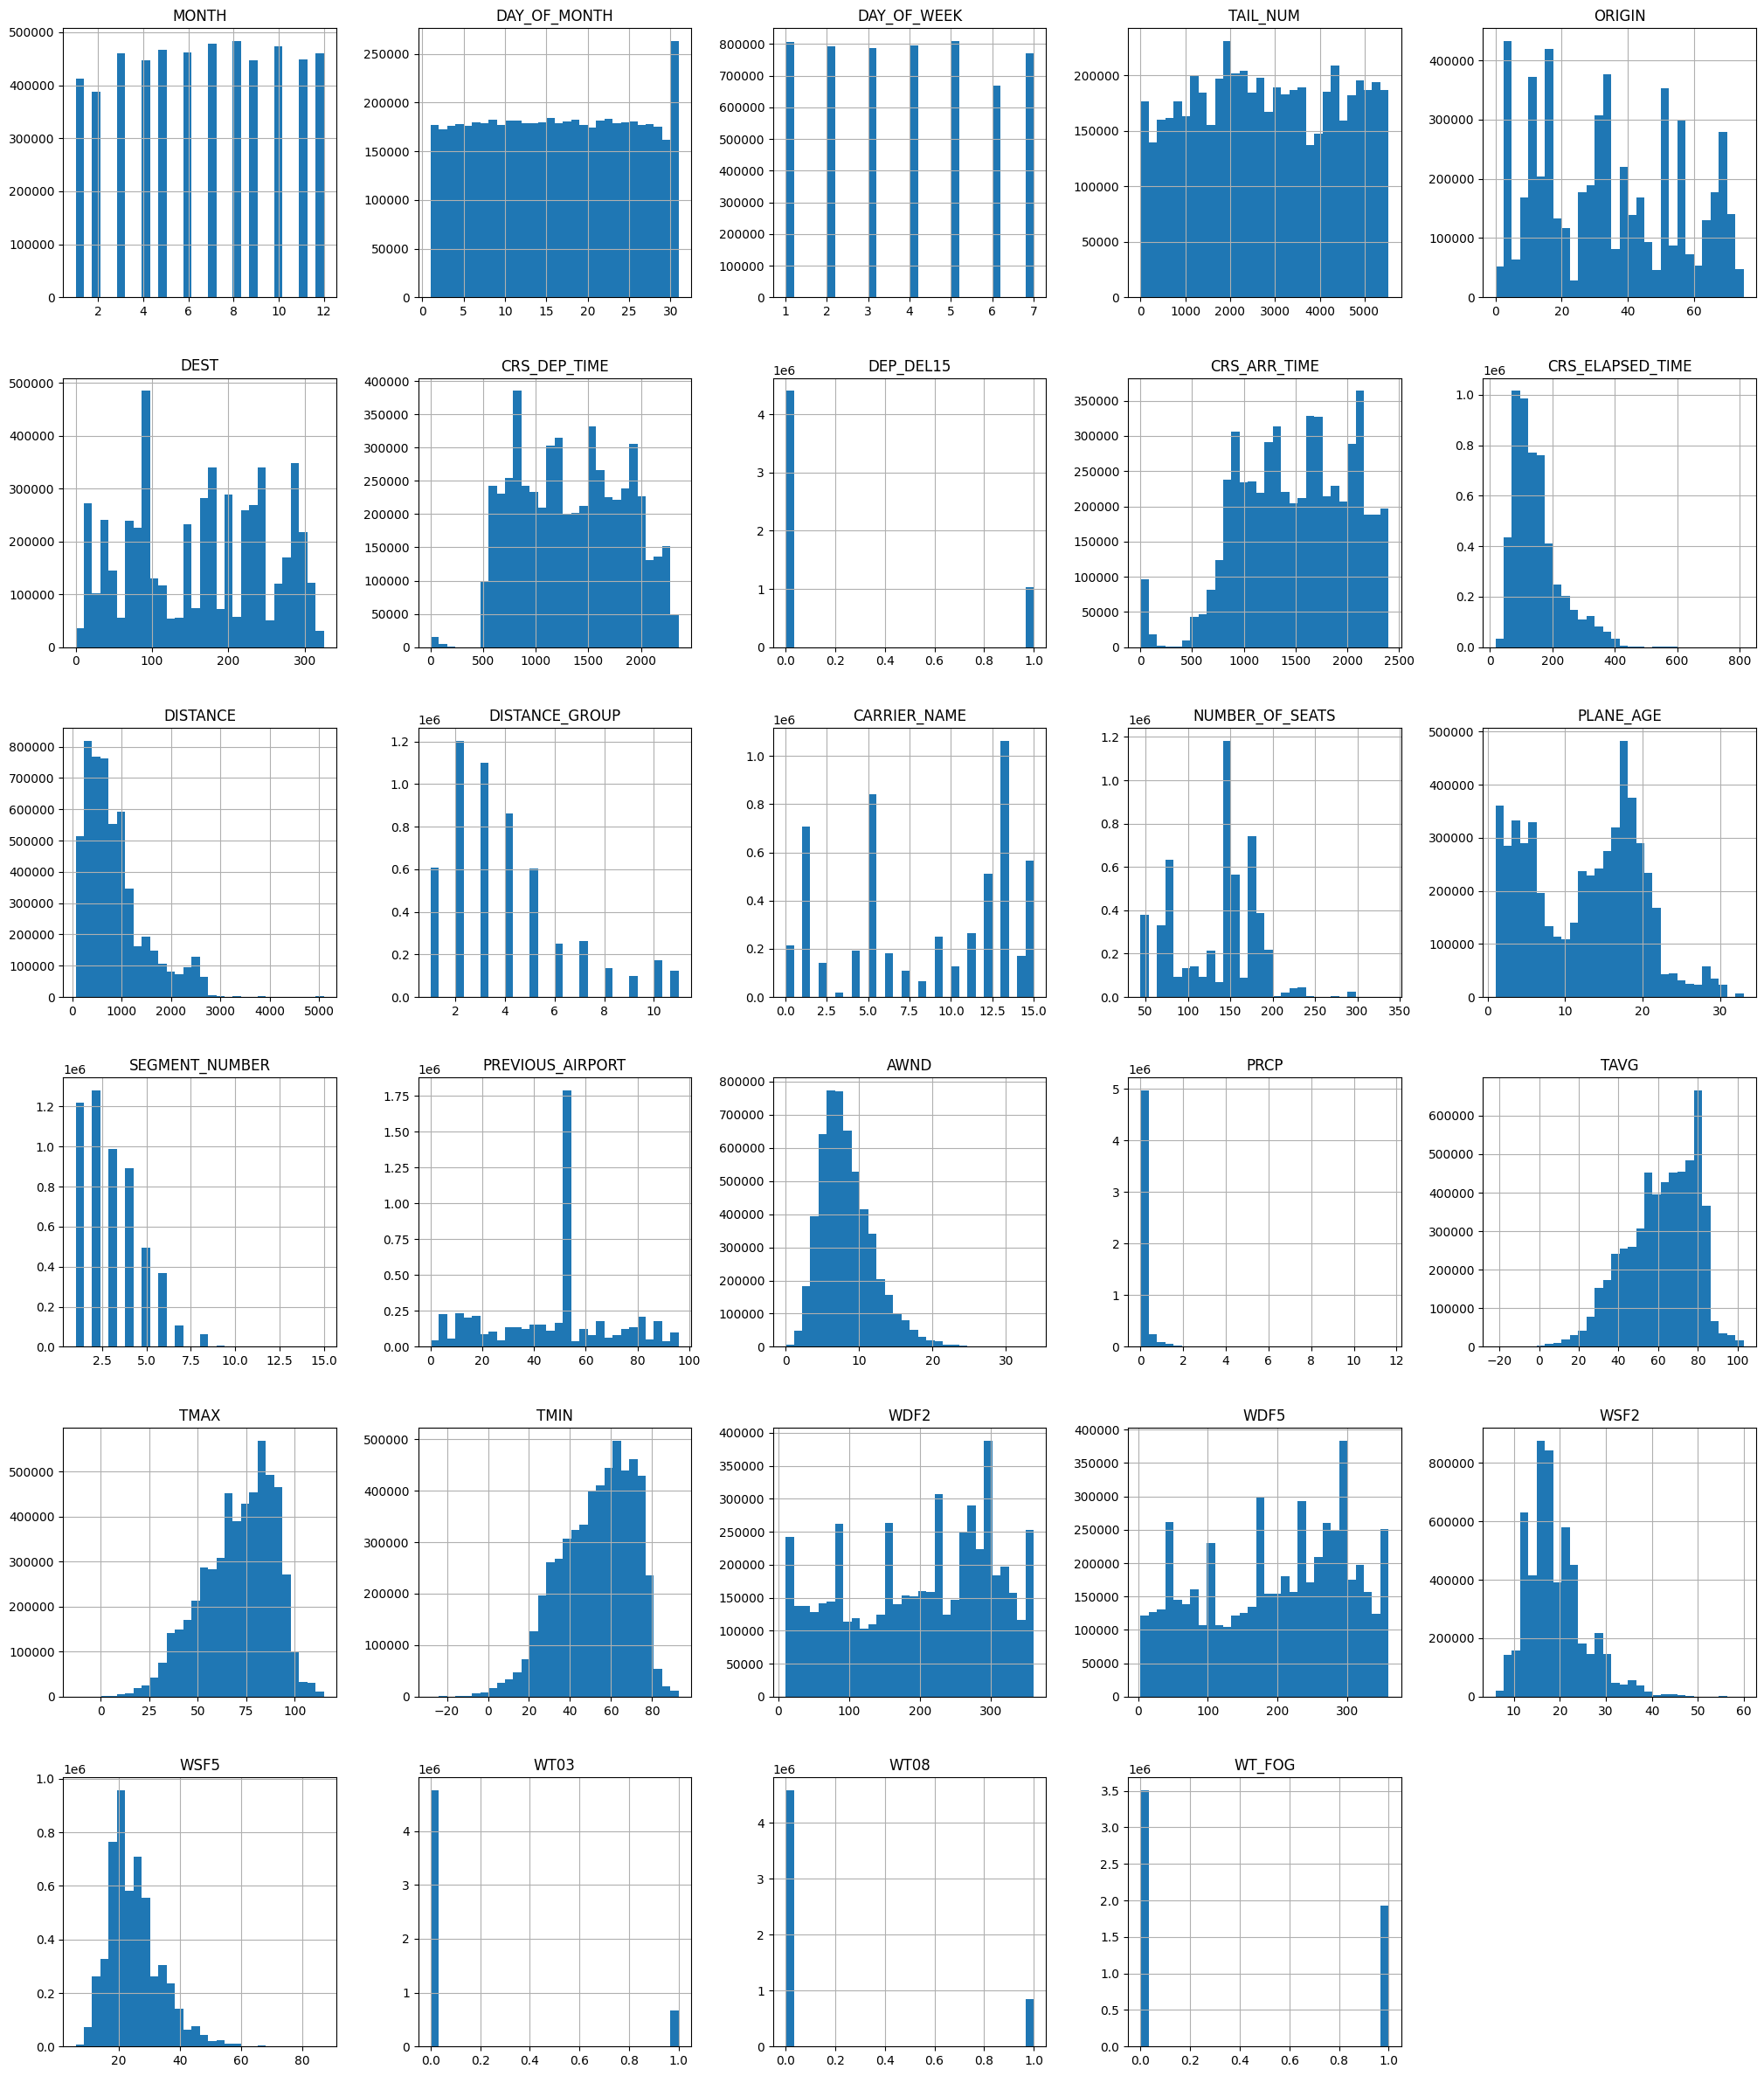

In [3]:
df.hist(bins=30, figsize=(25, 30));

### Balancing with SMOTE and training with XGBoost

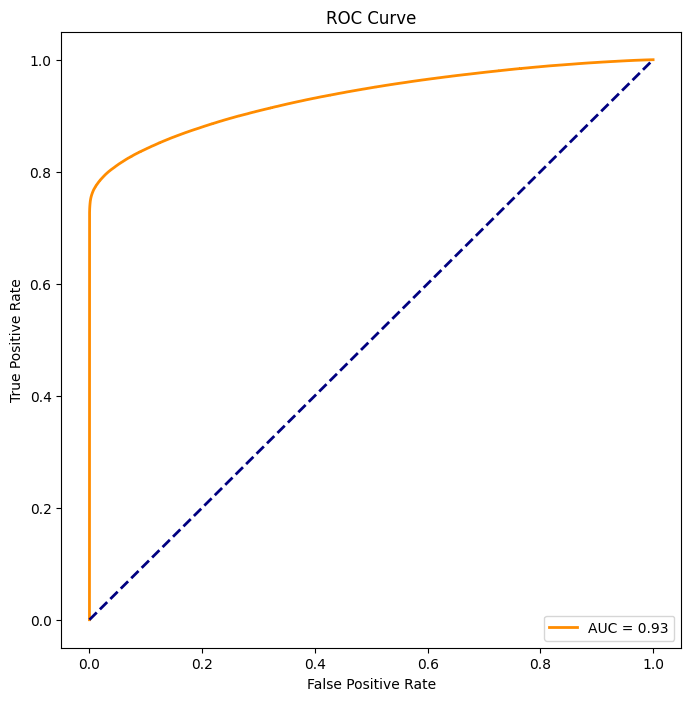

Accuracy: 0.8828473662639742
Confusion Matrix:
[[864731  16090]
 [190291 690530]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89    880821
         1.0       0.98      0.78      0.87    880821

    accuracy                           0.88   1761642
   macro avg       0.90      0.88      0.88   1761642
weighted avg       0.90      0.88      0.88   1761642



/Users/terlan/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 600x600 with 0 Axes>

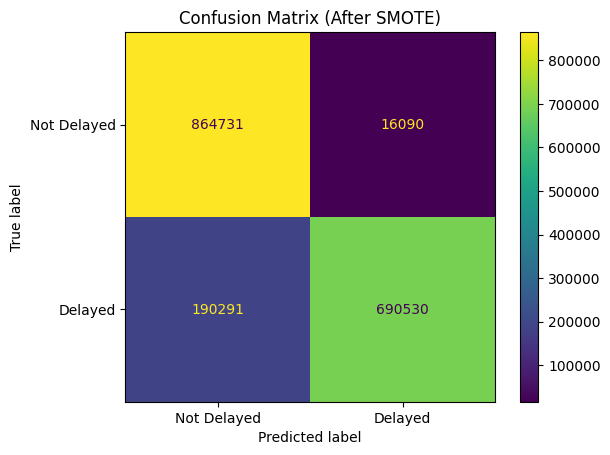

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

# features = [
#     'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
#     'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME',
#     'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_NAME', 'NUMBER_OF_SEATS',
#     'PLANE_AGE', 'SEGMENT_NUMBER', 'AWND', 'PRCP',
#     'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT03', 'WT08',
#     'WT_FOG'
# ]

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Perform SMOTE undersampling on the target variable to balance it
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Create and train an XGBoost classification model
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)


# Confusion matrix
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(model, X_test, y_test, display_labels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix (After SMOTE)')
plt.show()



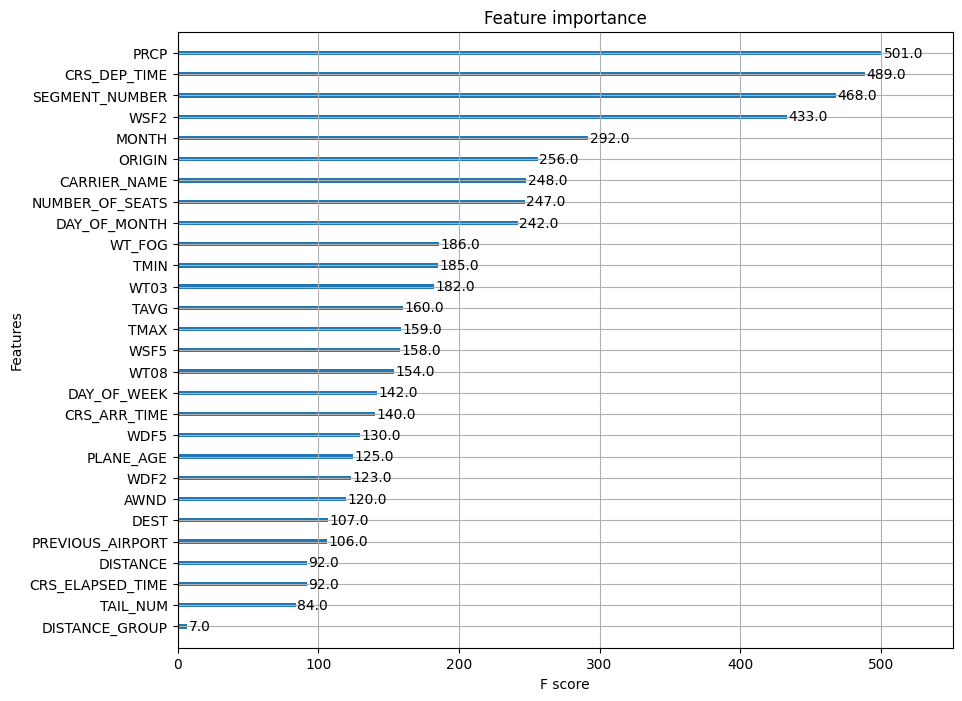

In [5]:
# plot feature importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model, ax=ax)
plt.show()

## Evaluation